In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/kaggle"

In [ ]:
%cd /content/drive/My Drive/kaggle

/content/drive/My Drive/kaggle


In [ ]:
!kaggle datasets download -d wanderdust/skin-lesion-analysis-toward-melanoma-detection

100% 11.3G/11.3G [03:05<00:00, 99.7MB/s]



In [ ]:
!ls

kaggle.json  skin-lesions


In [ ]:
!unzip \*.zip  && rm *.zip

Archive:  skin-lesion-analysis-toward-melanoma-detection.zip
  inflating: skin-lesions/test/melanoma/ISIC_0012258.jpg  
  inflating: skin-lesions/test/melanoma/ISIC_0012356.jpg  
  inflating: skin-lesions/test/melanoma/ISIC_0012369.jpg  
  inflating: skin-lesions/test/melanoma/ISIC_0012395.jpg  
  inflating: skin-lesions/test/melanoma/ISIC_0012425.jpg  
  inflating: skin-lesions/test/melanoma/ISIC_0012758.jpg  
  inflating: skin-lesions/test/melanoma/ISIC_0012989.jpg  
  inflating: skin-lesions/test/melanoma/ISIC_0013072.jpg  
  inflating: skin-lesions/test/melanoma/ISIC_0013073.jpg  
  inflating: skin-lesions/test/melanoma/ISIC_0013242.jpg  
  inflating: skin-lesions/test/melanoma/ISIC_0013277.jpg  
  inflating: skin-lesions/test/melanoma/ISIC_0013321.jpg  
  inflating: skin-lesions/test/melanoma/ISIC_0013374.jpg  
  inflating: skin-lesions/test/melanoma/ISIC_0013411.jpg  
  inflating: skin-lesions/test/melanoma/ISIC_0013414.jpg  
  inflating: skin-lesions/test/melanoma/ISIC_0013455.j

In [ ]:
!ls skin-lesions

test  train  valid


In [ ]:
base_dir ='/content/drive/My Drive/kaggle/skin-lesions'

train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
valid_dir = os.path.join(base_dir, 'valid')

train_melanoma_dir = os.path.join(train_dir, 'melanoma')
train_nevus_dir = os.path.join(train_dir, 'nevus')
train_seborrheic_keratosis_dir = os.path.join(train_dir, 'seborrheic_keratosis')

test_melanoma_dir = os.path.join(test_dir, 'melanoma')
test_nevus_dir = os.path.join(test_dir, 'nevus')
test_seborrheic_keratosis_dir = os.path.join(test_dir, 'seborrheic_keratosis')

valid_melanoma_dir = os.path.join(valid_dir, 'melanoma')
valid_nevus_dir = os.path.join(valid_dir, 'nevus')
valid_seborrheic_keratosis_dir = os.path.join(valid_dir, 'seborrheic_keratosis')

In [ ]:
print("total training melanoma images:", len(os.listdir(train_melanoma_dir))) #cek jumlah file
print("total training nevus images:", len(os.listdir(train_nevus_dir)))
print("total training seborrheic keratosis:", len(os.listdir(train_seborrheic_keratosis_dir)))
print("total test melanoma images:", len(os.listdir(test_melanoma_dir)))
print("total test nevus images:", len(os.listdir(test_nevus_dir)))
print("total test seborrheic keratosis image:", len(os.listdir(test_seborrheic_keratosis_dir)))
print("total valid melanoma image:", len(os.listdir(valid_melanoma_dir)))
print("total valid nevus image:", len(os.listdir(valid_nevus_dir)))
print("total valid seborrheic keratosis image:", len(os.listdir(valid_seborrheic_keratosis_dir)))

total training melanoma images: 374
total training nevus images: 1372
total training seborrheic keratosis: 254
total test melanoma images: 117
total test nevus images: 393
total test seborrheic keratosis image: 90
total valid melanoma image: 30
total valid nevus image: 78
total valid seborrheic keratosis image: 42


In [ ]:
from fastai import *
from fastai.vision import *

import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc,roc_curve
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib.pyplot import imread, imshow, subplots, show
from skimage import io
from matplotlib import cm
from mpl_toolkits.axes_grid1 import ImageGrid
import math

import os
% matplotlib inline

In [ ]:
Batch_size=32
augmen_gen = ImageDataGenerator(rescale=1. / 255,
                            rotation_range=40,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            zoom_range=0.2,
                            horizontal_flip=True,
                            fill_mode='nearest')
train_gen = augmen_gen.flow_from_directory(
    train_dir,
    class_mode = 'categorical',
    shuffle=True,
    target_size = (224,224),
    batch_size=Batch_size,
    color_mode ='rgb'
)

val_gen = augmen_gen.flow_from_directory(
    valid_dir,
    class_mode = 'categorical',
    shuffle=True,
    target_size = (224,224),
    batch_size=Batch_size,
    color_mode ='rgb'
)

test_gen = augmen_gen.flow_from_directory(
    test_dir,
    class_mode = 'categorical',
    shuffle=False,
    target_size = (224,224),
    batch_size=Batch_size,
    color_mode ='rgb',
)
tfms=get_transforms(flip_vert=True, max_warp=0.)

Found 2000 images belonging to 3 classes.
Found 150 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


In [ ]:
data = (ImageList.from_folder(train_dir)
        .random_split_by_pct()
        .label_from_folder()
        .transform(tfms, size=150)
        .databunch(num_workers=2, bs=32))

/usr/local/lib/python3.7/dist-packages/fastai/data_block.py:217: UserWarning: `random_split_by_pct` is deprecated, please use `split_by_rand_pct`.
  warn("`random_split_by_pct` is deprecated, please use `split_by_rand_pct`.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3500: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3500: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3500: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3500: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale

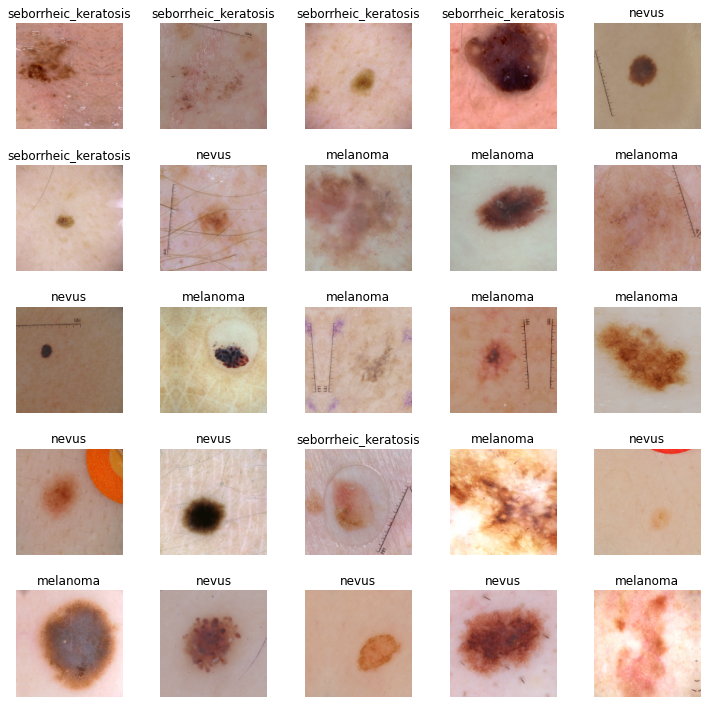

In [ ]:
data.show_batch(row=1, figsize=(10,10))

MODEL

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input
from tensorflow.keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
import keras

Model 1 VGG-19

In [ ]:
baseModel = VGG19(include_top=False, input_tensor=Input(shape=(224, 224, 3)))

In [ ]:
class FCHeadNet:
  def build(baseModel, classes, D):
    headModel = baseModel.output
    headModel = Flatten(name="flatten")(headModel)
    headModel = Dense(D, activation='elu')(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(classes, activation='sigmoid')(headModel)
    return headModel

In [ ]:
headModel = FCHeadNet.build(baseModel, 1, 256)
model1 = Model(inputs=baseModel.input, outputs=headModel)

In [ ]:
# mark loaded layers as not trainable
for layer in model1.layers:
	layer.trainable = False

In [ ]:
model1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
from tensorflow.keras.optimizers import Adam

model1.compile(optimizer=Adam(lr=1e-3), 
              loss='categorical_crossentropy', 
              metrics=['acc'])

Model 2 ResNet50

In [ ]:
restnet = ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3))

In [ ]:
headModel2 = FCHeadNet.build(restnet, 1, 256)
model2 = Model(inputs=restnet.input, outputs=headModel2)

for layer in model2.layers:
	layer.trainable = False

In [ ]:
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
model2.compile(optimizer=Adam(lr=1e-3), 
              loss='categorical_crossentropy', 
              metrics=['acc'])

Training Model 1 VGG-19

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
best_model_path = 'model1_6.h5'
metric = 'val_acc'
checkpoint_callback = ModelCheckpoint(best_model_path,
                                     monitor=metric,
                                     save_best_only=True,
                                     verbose=1)

In [ ]:
H = model1.fit_generator(train_gen,
                        validation_data=val_gen, epochs=15,callbacks=checkpoint_callback)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
63/63 [==============================] - 1700s 27s/step - loss: 1.0986 - acc: 0.5680 - val_loss: 1.0986 - val_acc: 0.6644

Epoch 00001: val_acc improved from -inf to 0.66444, saving model to model1_6.h5
Epoch 2/15
63/63 [==============================] - 1615s 26s/step - loss: 1.0986 - acc: 0.5731 - val_loss: 1.0986 - val_acc: 0.6667

Epoch 00002: val_acc improved from 0.66444 to 0.66667, saving model to model1_6.h5
Epoch 3/15
63/63 [==============================] - 1619s 26s/step - loss: 1.0986 - acc: 0.5670 - val_loss: 1.0986 - val_acc: 0.6644

Epoch 00003: val_acc did not improve from 0.66667
Epoch 4/15
63/63 [==============================] - 1611s 26s/step - loss: 1.0986 - acc: 0.5597 - val_loss: 1.0986 - val_acc: 0.6644

Epoch 00004: val_acc did not improve from 0.66667
Epoch 5/15
63/63 [==============================] - 1620s 26s/step - loss: 1.0986 - acc: 0.5701 - val_loss: 1.0986 - val_acc: 0.6644

Epoch 00005: val_acc did not improve from 0.66667
Epoch 6/15
63/63 

Training Model 2

In [ ]:
best_model_path2 = 'model2_6.h5'
checkpoint_callback2 = ModelCheckpoint(best_model_path2,
                                     monitor='val_acc',
                                     save_best_only=True,
                                     verbose=1)
H2 = model2.fit_generator(train_gen,
                        validation_data=val_gen, epochs=15,callbacks=checkpoint_callback2)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
63/63 [==============================] - 690s 11s/step - loss: 1.0986 - acc: 0.3520 - val_loss: 1.0986 - val_acc: 0.3333

Epoch 00001: val_acc improved from -inf to 0.33333, saving model to model2_6.h5
Epoch 2/15
63/63 [==============================] - 664s 10s/step - loss: 1.0986 - acc: 0.3506 - val_loss: 1.0986 - val_acc: 0.3333

Epoch 00002: val_acc did not improve from 0.33333
Epoch 3/15
63/63 [==============================] - 661s 10s/step - loss: 1.0986 - acc: 0.3483 - val_loss: 1.0986 - val_acc: 0.3333

Epoch 00003: val_acc did not improve from 0.33333
Epoch 4/15
63/63 [==============================] - 672s 11s/step - loss: 1.0986 - acc: 0.3556 - val_loss: 1.0986 - val_acc: 0.3333

Epoch 00004: val_acc did not improve from 0.33333
Epoch 5/15
63/63 [==============================] - 662s 10s/step - loss: 1.0986 - acc: 0.3526 - val_loss: 1.0986 - val_acc: 0.3333

Epoch 00005: val_acc did not improve from 0.33333
Epoch 6/15
63/63 [==============================] - 663

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
test_gen.class_indices

{'melanoma': 0, 'nevus': 1, 'seborrheic_keratosis': 2}

In [ ]:
test_gen.classes

array([0, 0, 0, 0, ..., 2, 2, 2, 2], dtype=int32)